# Task 2

I collected datasets of running and walking, where I did each activity for 150 seconds around a 200 meter track. My device was located in the pocket of a pair of jeans I was wearing.

# Task 3- Loading The Raw Data

#### Imports

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold

from tsfresh.feature_extraction import extract_features
from tsfresh.transformers import FeatureSelector
from tsfresh.feature_selection.relevance import calculate_relevance_table

%matplotlib inline

#### Loading the raw data

In [2]:
running_file_path = "../data/raw/running.csv"
running_df = pd.read_csv(running_file_path, names=["time", "ax", "ay", "az", "|a|"], skiprows=1, index_col=0, date_format="%H:%M:%S:%f")
running_df.head()

,ax,ay,az,|a|
time,,,,
1900-01-01 12:07:30.687,0.1959,-0.2976,-0.0124,0.357
1900-01-01 12:07:30.689,0.2785,-0.3342,0.2203,0.488
1900-01-01 12:07:30.693,0.2693,-0.2774,0.4570,0.599
1900-01-01 12:07:30.698,0.2972,-0.1997,0.5887,0.689
1900-01-01 12:07:30.703,0.3236,-0.1204,0.6637,0.748


In [3]:
walking_file_path = "../data/raw/walking.csv"
walking_df = pd.read_csv(walking_file_path, names=["time", "ax", "ay", "az", "|a|"], skiprows=1, index_col=0, date_format="%H:%M:%S:%f")
walking_df.head()

,ax,ay,az,|a|
time,,,,
1900-01-01 12:03:57.522,-0.4360,0.0265,0.5918,0.736
1900-01-01 12:03:57.523,-0.3297,-0.0361,0.6131,0.697
1900-01-01 12:03:57.526,-0.2099,-0.1039,0.6394,0.681
1900-01-01 12:03:57.529,-0.0521,-0.2148,0.6327,0.670
1900-01-01 12:03:57.533,0.0104,-0.2642,0.5506,0.611


# Task 4- Visualizing The Raw Data

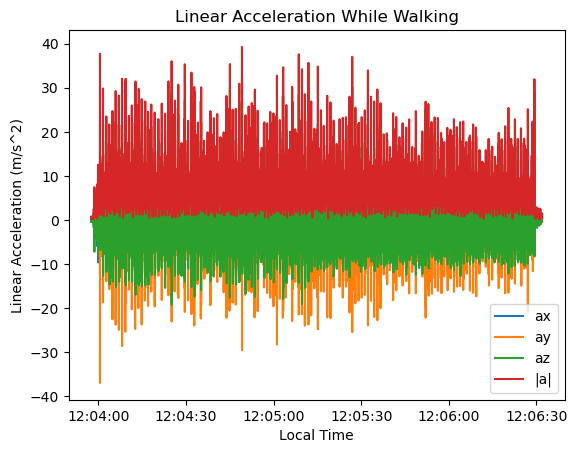

In [4]:
plt.plot(walking_df)
plt.xlabel("Local Time")
plt.ylabel("Linear Acceleration (m/s^2)")
plt.title("Linear Acceleration While Walking")
plt.legend(["ax", "ay", "az", "|a|"])
plt.show()

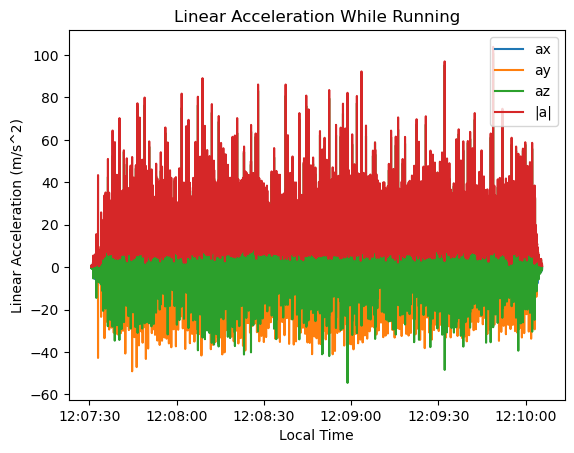

In [5]:
plt.plot(running_df)
plt.xlabel("Local Time")
plt.ylabel("Linear Acceleration (m/s^2)")
plt.title("Linear Acceleration While Running")
plt.legend(["ax", "ay", "az", "|a|"])
plt.show()

#### Describing the raw data

One obvious difference is the magnitude of linear acceleration. In the running dataset, the absolute linear acceleration reaches up to 100 m/s^2, with average lows outside of the transition periods of around 30 to 40m/s^2. Compare this with the walking dataset, which reaches a high of about 40m/s^2, and averaging around 10 to 15m/s^2 on the low end during the walking period.

Another difference is the smoothness of transition between peaks and lows. In the walking graph, there are often gaps between similar datapoints creating a haircomb-like effect in the graph, whereas the peaks and troughs are much more solid and distinct in the running graph.

The transition periods in the walking data seem to be before 12:04:05 and after 12:06:29. For the running data, it seems to be before 12:07:40 and after 12:09:56.

# Task 5- Preprocessing The Data

#### Computing and adding delta_t columns

In [6]:
delta_t = walking_df.index - walking_df.index[0]
walking_df["delta_t"] = delta_t.seconds + delta_t.microseconds / 1e6
walking_df.head()

,ax,ay,az,|a|,delta_t
time,,,,,
1900-01-01 12:03:57.522,-0.4360,0.0265,0.5918,0.736,0.000
1900-01-01 12:03:57.523,-0.3297,-0.0361,0.6131,0.697,0.001
1900-01-01 12:03:57.526,-0.2099,-0.1039,0.6394,0.681,0.004
1900-01-01 12:03:57.529,-0.0521,-0.2148,0.6327,0.670,0.007
1900-01-01 12:03:57.533,0.0104,-0.2642,0.5506,0.611,0.011


In [7]:
delta_t = running_df.index - running_df.index[0]
running_df["delta_t"] = delta_t.seconds + delta_t.microseconds / 1e6
running_df.head()

,ax,ay,az,|a|,delta_t
time,,,,,
1900-01-01 12:07:30.687,0.1959,-0.2976,-0.0124,0.357,0.000
1900-01-01 12:07:30.689,0.2785,-0.3342,0.2203,0.488,0.002
1900-01-01 12:07:30.693,0.2693,-0.2774,0.4570,0.599,0.006
1900-01-01 12:07:30.698,0.2972,-0.1997,0.5887,0.689,0.011
1900-01-01 12:07:30.703,0.3236,-0.1204,0.6637,0.748,0.016


#### Pruning the data to get rid of transition periods

In [8]:
walking_mask = (walking_df["delta_t"] >= 8) & (walking_df["delta_t"] <= 151)
walking_df_pruned = walking_df[walking_mask].copy()
walking_df_pruned

,ax,ay,az,|a|,delta_t
time,,,,,
1900-01-01 12:04:05.526,4.2521,-7.3263,-2.9138,8.958,8.004
1900-01-01 12:04:05.531,4.9399,-7.9341,-2.9995,9.816,8.009
1900-01-01 12:04:05.535,5.6255,-8.3854,-3.1721,10.584,8.013
1900-01-01 12:04:05.541,6.1374,-8.6561,-3.2832,11.107,8.019
1900-01-01 12:04:05.545,6.7103,-8.6506,-3.3090,11.437,8.023
...,...,...,...,...,...
1900-01-01 12:06:28.500,0.4391,4.3946,-1.4156,4.638,150.978
1900-01-01 12:06:28.505,1.1717,5.0897,-3.2849,6.170,150.983
1900-01-01 12:06:28.510,1.8180,5.3651,-5.1219,7.637,150.988


In [9]:
running_mask = (running_df["delta_t"] >= 10) & (running_df["delta_t"] <= 145)
running_df_pruned = running_df[running_mask].copy()
running_df_pruned

,ax,ay,az,|a|,delta_t
time,,,,,
1900-01-01 12:07:40.690,-8.7296,10.6767,22.5546,26.437,10.003
1900-01-01 12:07:40.697,-8.0197,10.2981,16.9444,21.389,10.010
1900-01-01 12:07:40.699,-6.9704,10.1747,9.9304,15.834,10.012
1900-01-01 12:07:40.704,-6.0943,10.2423,4.5867,12.770,10.017
1900-01-01 12:07:40.709,-5.7340,10.3513,2.0075,12.002,10.022
...,...,...,...,...,...
1900-01-01 12:09:55.667,5.2020,-3.2536,-1.7164,6.371,144.980
1900-01-01 12:09:55.672,7.6888,-0.1188,-1.1062,7.769,144.985
1900-01-01 12:09:55.676,8.2936,1.9035,-0.8895,8.556,144.989


#### Displaying pruned data

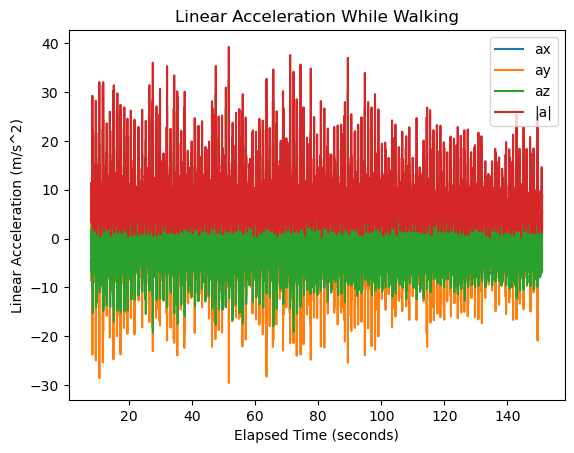

In [10]:
plt.plot(walking_df_pruned["delta_t"], walking_df_pruned.iloc[:,:4])
plt.xlabel("Elapsed Time (seconds)")
plt.ylabel("Linear Acceleration (m/s^2)")
plt.title("Linear Acceleration While Walking")
plt.legend(["ax", "ay", "az", "|a|"])
plt.show()

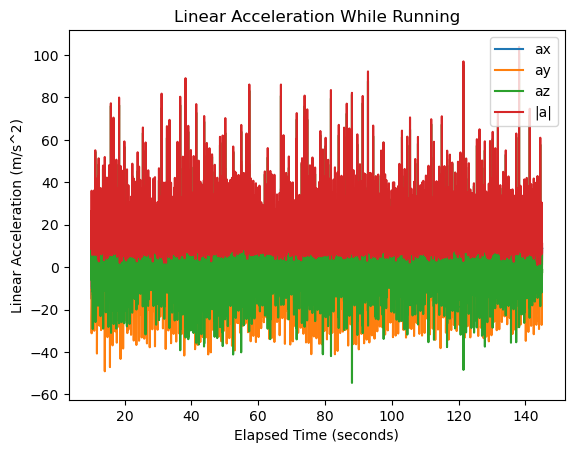

In [11]:
plt.plot(running_df_pruned["delta_t"], running_df_pruned.iloc[:,:4])
plt.xlabel("Elapsed Time (seconds)")
plt.ylabel("Linear Acceleration (m/s^2)")
plt.title("Linear Acceleration While Running")
plt.legend(["ax", "ay", "az", "|a|"])
plt.show()

In [12]:
walking_length = walking_df[walking_mask].iloc[-1]["delta_t"] - walking_df[walking_mask].iloc[0]["delta_t"]
running_length = running_df[running_mask].iloc[-1]["delta_t"] - running_df[running_mask].iloc[0]["delta_t"]

walking_length, running_length

(142.99300000000002, 134.99599999999998)

##### The remaining lengths for walking and running are 142.993 and 134.996 seconds respectively

# Task 6- Extracting Features

#### Adding windows_idx columns

In [13]:
walking_df_pruned['windows_idx'] = np.array(["w" + ele for ele in ((np.floor(walking_df_pruned.reset_index().index / 100).values).astype(int)).astype(str)])
walking_df_pruned

,ax,ay,az,|a|,delta_t,windows_idx
time,,,,,,
1900-01-01 12:04:05.526,4.2521,-7.3263,-2.9138,8.958,8.004,w0
1900-01-01 12:04:05.531,4.9399,-7.9341,-2.9995,9.816,8.009,w0
1900-01-01 12:04:05.535,5.6255,-8.3854,-3.1721,10.584,8.013,w0
1900-01-01 12:04:05.541,6.1374,-8.6561,-3.2832,11.107,8.019,w0
1900-01-01 12:04:05.545,6.7103,-8.6506,-3.3090,11.437,8.023,w0
...,...,...,...,...,...,...
1900-01-01 12:06:28.500,0.4391,4.3946,-1.4156,4.638,150.978,w305
1900-01-01 12:06:28.505,1.1717,5.0897,-3.2849,6.170,150.983,w305
1900-01-01 12:06:28.510,1.8180,5.3651,-5.1219,7.637,150.988,w305


In [14]:
running_df_pruned['windows_idx'] = np.array(["r" + ele for ele in ((np.floor(running_df_pruned.reset_index().index / 100).values).astype(int)).astype(str)])
running_df_pruned

,ax,ay,az,|a|,delta_t,windows_idx
time,,,,,,
1900-01-01 12:07:40.690,-8.7296,10.6767,22.5546,26.437,10.003,r0
1900-01-01 12:07:40.697,-8.0197,10.2981,16.9444,21.389,10.010,r0
1900-01-01 12:07:40.699,-6.9704,10.1747,9.9304,15.834,10.012,r0
1900-01-01 12:07:40.704,-6.0943,10.2423,4.5867,12.770,10.017,r0
1900-01-01 12:07:40.709,-5.7340,10.3513,2.0075,12.002,10.022,r0
...,...,...,...,...,...,...
1900-01-01 12:09:55.667,5.2020,-3.2536,-1.7164,6.371,144.980,r288
1900-01-01 12:09:55.672,7.6888,-0.1188,-1.1062,7.769,144.985,r288
1900-01-01 12:09:55.676,8.2936,1.9035,-0.8895,8.556,144.989,r288


#### Checking last window to see if it has 100 samples. If not, remove it with a mask

In [15]:
walking_df_pruned[walking_df_pruned["windows_idx"] == walking_df_pruned.iloc[-1, 5]].shape

(42, 6)

In [16]:
walking_window_mask = walking_df_pruned["windows_idx"] != "w305"

In [17]:
running_df_pruned[running_df_pruned["windows_idx"] == running_df_pruned.iloc[-1, 5]].shape

(33, 6)

In [18]:
running_window_mask = running_df_pruned["windows_idx"] != "r288"

#### Concatenating the DataFrames

In [19]:
walking_df_pruned[walking_window_mask].shape, running_df_pruned[running_window_mask].shape

((30500, 6), (28800, 6))

##### The shape of the DataFrames before feature extraction are (30500, 6), and (28800, 6) for walking and running respectively

In [20]:
naive_feature_matrix = pd.concat([walking_df_pruned[walking_window_mask], running_df_pruned[running_window_mask]], axis=0)
naive_feature_matrix.shape

(59300, 6)

##### The shape of the DataFrame after concatenation is (59300, 6)

In [21]:
len(np.unique(naive_feature_matrix["windows_idx"]))

593

##### We have 593 unique values of the column windows_idx

#### Applying feature extraction to compute a systematic time series feature matrix from the naive feature matrix

In [22]:
feature_matrix = extract_features(naive_feature_matrix, column_id="windows_idx", column_sort="delta_t")
feature_matrix.shape

Feature Extraction: 100%|██████████| 20/20 [00:40<00:00,  2.01s/it]


(593, 3152)

In [23]:
feature_matrix.shape

(593, 3152)

In [24]:
# The ordering is such because windows_idx is a string, and when ordering strings it goes element-wise

feature_matrix = feature_matrix.dropna(axis=1)
print(feature_matrix.shape)
feature_matrix.head()

(593, 2364)


,|a|__variance_larger_than_standard_deviation,|a|__has_duplicate_max,|a|__has_duplicate_min,|a|__has_duplicate,|a|__sum_values,|a|__abs_energy,|a|__mean_abs_change,|a|__mean_change,|a|__mean_second_derivative_central,|a|__median,...,az__fourier_entropy__bins_3,az__fourier_entropy__bins_5,az__fourier_entropy__bins_10,az__fourier_entropy__bins_100,az__permutation_entropy__dimension_3__tau_1,az__permutation_entropy__dimension_4__tau_1,az__permutation_entropy__dimension_5__tau_1,az__permutation_entropy__dimension_6__tau_1,az__permutation_entropy__dimension_7__tau_1,az__mean_n_absolute_max__number_of_maxima_7
r0,1.0,0.0,0.0,1.0,1569.202,28598.704370,1.603657,-0.085232,0.078974,14.2740,...,0.261160,0.261160,0.481199,1.336278,1.395431,2.247597,3.003866,3.607328,4.037966,20.047600
r1,1.0,0.0,0.0,1.0,1662.010,32081.899966,1.962646,-0.038283,0.000087,16.5565,...,0.443757,0.518641,0.612670,1.434748,1.240392,1.878792,2.421092,2.922382,3.314735,24.759000
r10,1.0,0.0,0.0,0.0,1674.730,34232.200012,1.546414,0.069747,-0.040995,15.9615,...,0.522640,0.752532,1.021550,1.919029,1.417986,2.215370,3.065877,3.704751,4.171911,17.703686
r100,1.0,0.0,0.0,0.0,1697.431,35987.609685,1.924727,0.012768,0.007755,15.3290,...,0.319026,0.413917,0.612670,1.665962,1.402545,2.141888,2.887569,3.496385,3.941961,30.261957
r101,1.0,0.0,0.0,0.0,1794.175,43705.651861,2.805909,0.058758,-0.014311,14.2215,...,0.319026,0.383650,0.602410,1.334093,1.364755,2.025364,2.630011,3.224168,3.620249,38.427871


##### The dimensions of the resulting feature matrix are (593, 3152), meaning that 3152 features have been extracted. However, after dropping columns with NaN entries, the dimensions of the feature matrix are (593, 2364) meaning there are 2364 features with all numerical entries.

# Task 8- Activity Recognition Model

#### Reducing the number of features

In [25]:
# Need to create a target/label vector

y = pd.DataFrame(index=feature_matrix.index)
y['is_running'] = y.index.str.startswith('r')
y = y.iloc[:, 0]
y

r0       True
r1       True
r10      True
r100     True
r101     True
        ...  
w95     False
w96     False
w97     False
w98     False
w99     False
Name: is_running, Length: 593, dtype: bool

In [26]:
select = FeatureSelector()
select.fit(feature_matrix, y)

FeatureSelector()

In [27]:
X_selected = select.transform(feature_matrix.dropna(axis=1))
X_selected

,|a|__median,|a|__quantile__q_0.2,|a|__quantile__q_0.6,|a|__quantile__q_0.4,|a|__quantile__q_0.7,"ax__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2","ax__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2","ax__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0",|a|__quantile__q_0.3,|a|__root_mean_square,...,"az__fft_coefficient__attr_""angle""__coeff_33","ay__fft_coefficient__attr_""angle""__coeff_44","|a|__fft_coefficient__attr_""angle""__coeff_36","ax__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""mean""",ax__lempel_ziv_complexity__bins_10,"ay__fft_coefficient__attr_""angle""__coeff_33",ay__median,"ay__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""var""",az__index_mass_quantile__q_0.7,"ax__change_quantiles__f_agg_""mean""__isabs_False__qh_0.4__ql_0.0"
r0,14.2740,11.2128,14.9140,13.0682,16.6280,0.776683,1.138134,1.113743,12.5217,16.911151,...,-40.116900,-43.858756,86.674475,-1.769860,0.42,-24.439979,4.98265,-0.121439,0.87,-0.083947
r1,16.5565,10.6432,17.8380,13.7562,19.0358,0.859935,1.761077,1.007542,11.7310,17.911421,...,-65.903308,-11.581925,-83.268749,4.494952,0.36,-31.265092,-1.23120,0.275075,0.61,-0.082325
r10,15.9615,10.9394,16.5974,13.7038,17.5496,0.964309,1.947708,0.960873,11.8801,18.501946,...,-83.351827,-12.081434,-123.111198,-2.667570,0.43,-18.717864,7.04520,0.257882,0.78,-0.075378
r100,15.3290,10.7492,15.9288,13.0218,17.4688,1.078527,2.628927,1.086777,11.9582,18.970401,...,43.779904,-63.257735,177.976187,-0.659886,0.40,-85.342014,5.51940,-0.118768,0.87,-0.158230
r101,14.2215,11.4668,16.2058,13.2930,18.4259,1.319078,4.906967,1.170471,12.4101,20.905897,...,-164.524301,-18.478290,112.784098,4.895474,0.41,-36.696074,-0.50500,0.439013,0.46,-0.001200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
w95,8.6010,6.4934,9.3060,8.2760,10.5035,0.573987,0.591719,0.573527,7.8109,10.909595,...,170.326850,12.420362,36.992101,0.434604,0.41,-22.506088,3.48690,0.609992,0.75,0.013124
w96,4.6795,3.1264,5.0222,3.9688,5.5725,0.316220,0.130603,0.306503,3.6598,6.096798,...,121.773497,-66.247195,-66.816745,-1.004572,0.41,-165.937280,-1.36545,-0.055936,0.77,0.004114
w97,7.2560,5.8846,7.9602,6.8642,8.5973,0.492108,0.327197,0.502516,6.5353,8.790604,...,-40.855307,172.056557,145.011540,1.178238,0.45,145.734207,2.29135,0.665120,0.78,0.071268
w98,6.1655,2.9478,6.9446,5.0282,8.2465,0.314830,0.198411,0.267290,3.3473,8.202550,...,-177.927502,-4.747934,100.855115,2.416630,0.38,-7.309875,0.14785,-0.705123,0.49,-0.024644


#### Calculating and visualizing the 5 features with smallest p-value

In [28]:
relevance_table = calculate_relevance_table(X_selected, y)

In [29]:
relevance_table.sort_values(by="p_value").head()

,feature,type,p_value,relevant
feature,,,,
|a|__median,|a|__median,real,1.758756e-98,True
|a|__quantile__q_0.2,|a|__quantile__q_0.2,real,1.758824e-98,True
|a|__quantile__q_0.6,|a|__quantile__q_0.6,real,1.758869e-98,True
|a|__quantile__q_0.4,|a|__quantile__q_0.4,real,1.758869e-98,True
|a|__quantile__q_0.7,|a|__quantile__q_0.7,real,1.758880e-98,True


##### The five features with the smallest p-values are shown above

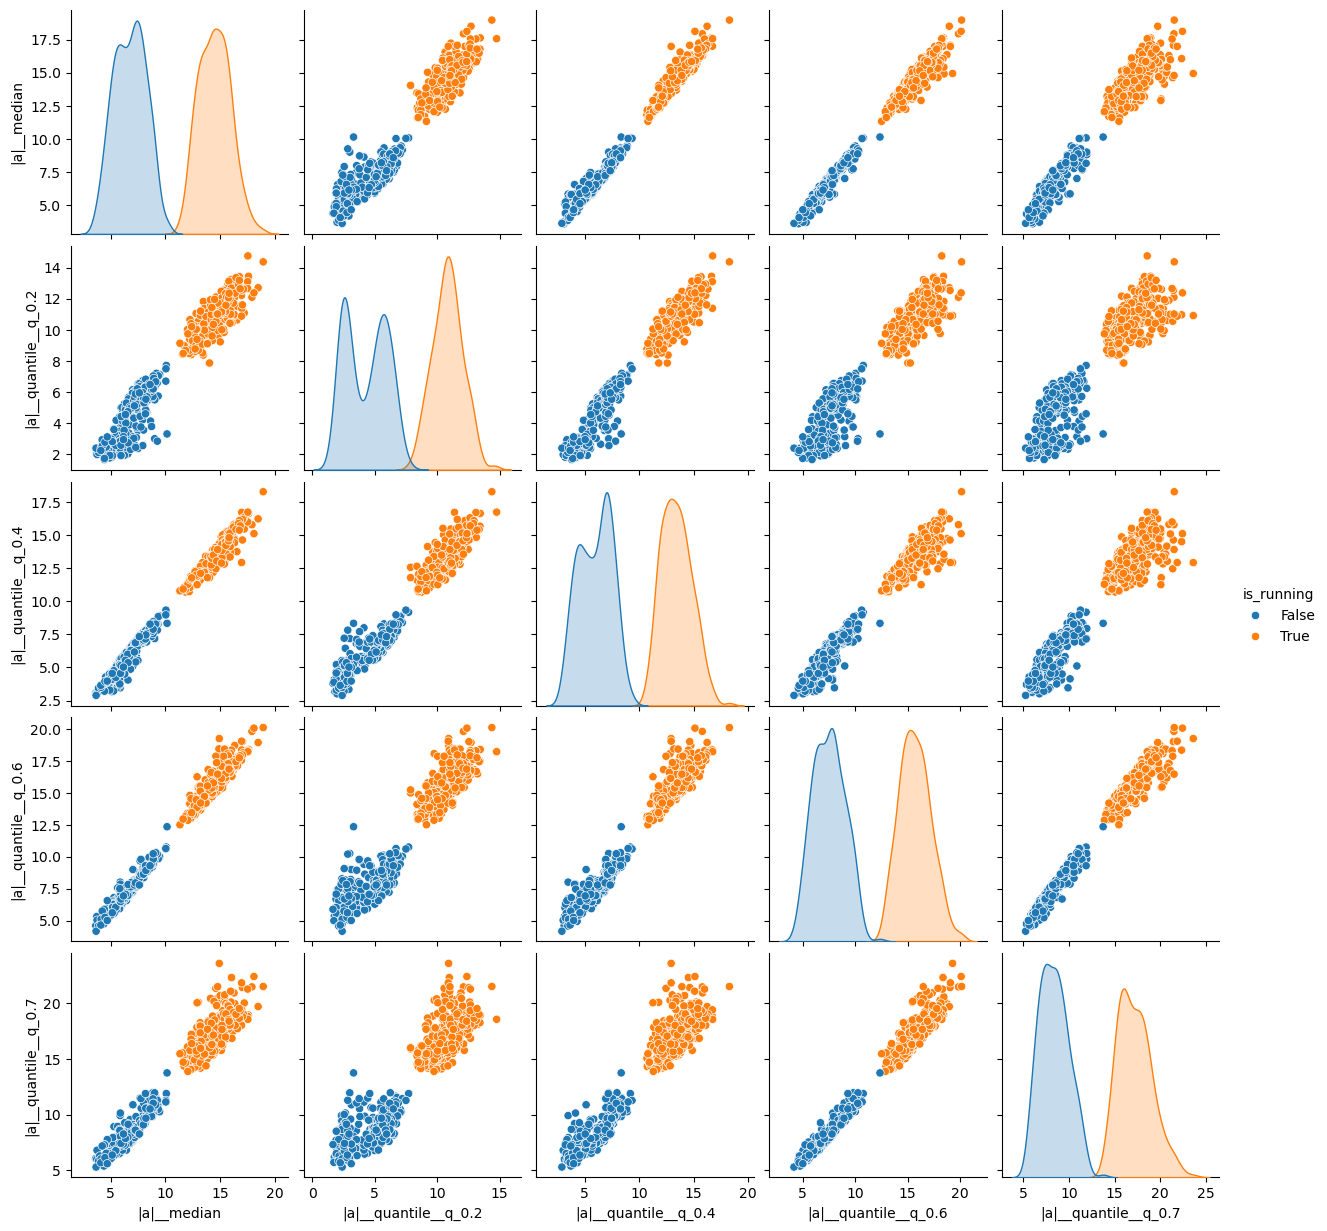

In [30]:
five_relevant_features = X_selected[["|a|__median", "|a|__quantile__q_0.2", "|a|__quantile__q_0.4", "|a|__quantile__q_0.6", "|a|__quantile__q_0.7"]].copy()

five_relevant_features["is_running"] = y
sns.pairplot(five_relevant_features, hue="is_running")

plt.show()

#### Observations from the pair plot

It's clear that a combination of any two features is able to show quite a strong correlation between running and walking. Even single features, as shown on the main diagonal, have very clear distinctions between running and walking, showing that they're strong predictors for the two categories. The only point on the multivariate feature plots where there's any datapoint overlap is the plot of |a|_quantile_q_0.6 and |a|_quantile_q_0.7 where one walking datapoint is on the boundary of the running cluster. Otherwise, there's a clear gap between the two classes on all other multivariate plots.

#### Evaluaitng Random Forest Classifier performance on statistically significant features

In [31]:
model = RandomForestClassifier()

cross_validation = RepeatedStratifiedKFold(n_splits=10, n_repeats=10)

scores = cross_val_score(model, X_selected, y, cv=cross_validation)
scores, np.mean(scores), np.unique(scores)

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 1.0,
 array([1.]))

#### Evaluating the classifier for recognising the two activities

The classifier can perfectly distinguish between the two activities, as shown by the scores having only one unique value which is 1. The scores array shows the prediction accuracy for each split. As no scoring metric is passed to the cross_val_score function, the RandomForestClassifier's default scoring metric is used which is mean accuracy.

Since we're doing 10 splits, then at the start of each repitition the data is split into 10 folds, with the proportion of running and walking classes being the same or similar between folds due to using stratified folds. The model is then trained on 9 folds and tested on the remaining fold, for all folds. This process is repeated with different splits 10 times, giving our scores array a size of 100.

For all 100 tests, the model is able to predict the activity without error, and so for this classification task the Random Forest Classifier is extremely effective.

#### Fitting Random Forest Classifier on all features

In [32]:
all_features_model = RandomForestClassifier()

all_features_model.fit(feature_matrix, y)

RandomForestClassifier()

In [33]:
feature_importances = pd.DataFrame(all_features_model.feature_importances_, columns=["feature_importance"], index=feature_matrix.columns)
feature_importances_sorted = feature_importances.sort_values(by="feature_importance", ascending=False)
feature_importances_sorted.head()

,feature_importance
"ax__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.2",0.050531
ax__absolute_sum_of_changes,0.043120
"ax__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0",0.030653
|a|__quantile__q_0.2,0.030267
|a|__quantile__q_0.1,0.029664


The five most important features are listed above alongside their importance.

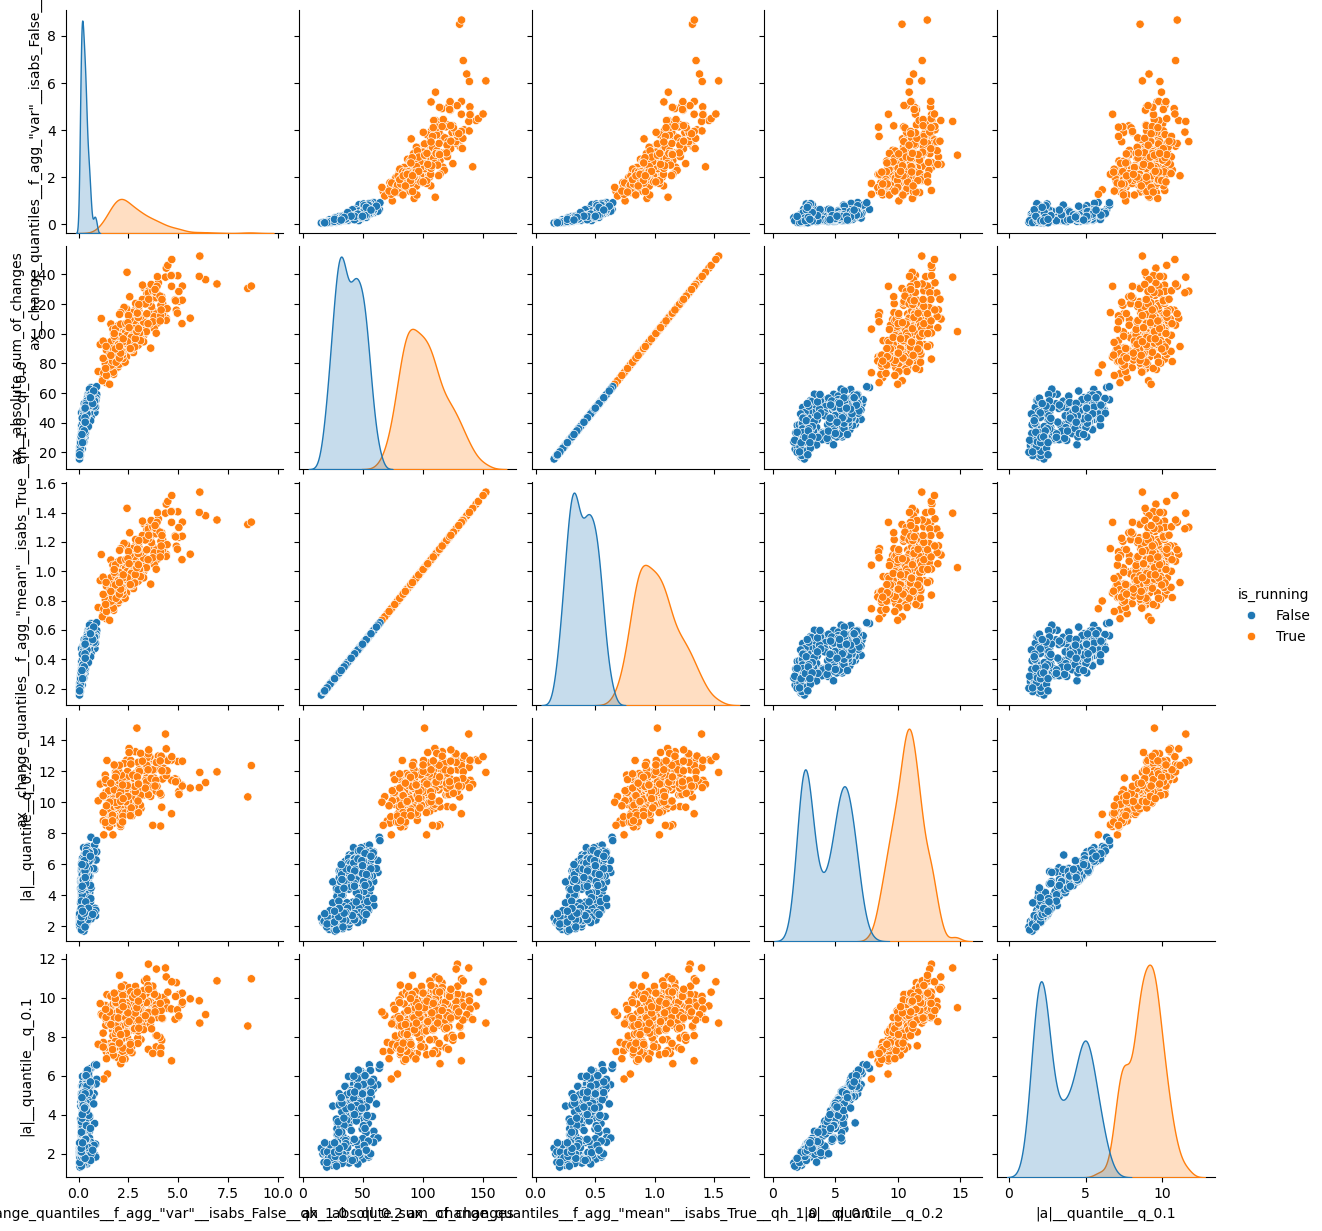

In [34]:
five_feature_names = feature_importances_sorted.iloc[:5, :].index

five_important_features = feature_matrix[five_feature_names.tolist()].copy()

five_important_features["is_running"] = y
sns.pairplot(five_important_features, hue="is_running")

plt.show()

#### Interpreting the visualisation

Each feature individually is already quite good at classifying, as there are very clear distinctions between the running and walking data on the main diagonal with little overlap in their ranges. 

When utilizing two distinct selected features, the differences between classes becomes relatively clear with generally well separated clusters for running and walking, and few overlapping datapoints between them. So, for multivariate feature selecting, the Random Forest Classifier is very well able to select features that can classify the input into the two categories.